In [1]:
from src.partition import Partition
from src.generators import PartitionClass
import numpy as np
import os

import plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Dense, Conv2D, Flatten, 
    ConvLSTM2D, BatchNormalization,
    Conv3D, Input, MaxPooling2D, UpSampling2D, Lambda
)
from keras.utils import plot_model
from keras.callbacks.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

Using TensorFlow backend.


In [2]:
n = 20

In [3]:
training_partitions = set(max(p, p.conjugate) for p in PartitionClass(n).partitions)
training_matrices = [p.matrix for p in training_partitions]
training_targets = [p.oblak.matrix for p in training_partitions]

X = np.array(training_matrices).reshape(-1, n, n, 1)
y = np.array(training_targets).reshape(-1, n, n, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# VAE

In [4]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [11]:
X_train = X_train.reshape((-1, n*n))
y_train = y_train.reshape((-1, n*n))
X_test = X_test.reshape((-1, n*n))
y_test = y_test.reshape((-1, n*n))

In [12]:
image_size = n
original_dim = n * n

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 100
latent_dim = 3
epochs = 1000

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 400)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          205312      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            1539        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            1539        dense_4[0][0]                    
____________________________________________________________________________________________

In [15]:
models = (encoder, decoder)
data = (X_test, y_test)

def vae_loss(inputs, outputs):
    xent_loss = original_dim * keras.losses.binary_crossentropy(inputs, outputs)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss = vae_loss)
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
es = EarlyStopping(monitor='val_loss', min_delta=.001, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
cbs = [es, lr]

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 400)               0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 208390    
_________________________________________________________________
decoder (Model)              (None, 400)               207248    
Total params: 415,638
Trainable params: 415,638
Non-trainable params: 0
_________________________________________________________________


In [16]:
vae.fit(X_train,
        X_train,
        epochs=epochs,
        batch_size=10,#batch_size,
        validation_data=(X_test, X_test),
        callbacks = cbs,
        workers = 4
        )

vae.save(f'serialization/models/vae_{n}.h5')

Train on 237 samples, validate on 80 samples
Epoch 1/1000
237/237 [==============================] - 0s 2ms/step - loss: 163.0570 - val_loss: 55.7598
Epoch 2/1000
237/237 [==============================] - 0s 437us/step - loss: 41.6874 - val_loss: 30.7983
Epoch 3/1000
237/237 [==============================] - 0s 456us/step - loss: 27.3722 - val_loss: 24.5738
Epoch 4/1000
237/237 [==============================] - 0s 454us/step - loss: 23.9341 - val_loss: 22.2777
Epoch 5/1000
237/237 [==============================] - 0s 501us/step - loss: 21.5339 - val_loss: 21.0876
Epoch 6/1000
237/237 [==============================] - 0s 449us/step - loss: 20.2761 - val_loss: 20.1105
Epoch 7/1000
237/237 [==============================] - 0s 435us/step - loss: 19.4127 - val_loss: 18.3669
Epoch 8/1000
237/237 [==============================] - 0s 444us/step - loss: 17.4553 - val_loss: 16.9939
Epoch 9/1000
237/237 [==============================] - 0s 445us/step - loss: 16.0277 - val_loss: 16.1745
Ep

Epoch 154/1000
237/237 [==============================] - 0s 488us/step - loss: 9.0113 - val_loss: 10.1294
Epoch 155/1000
237/237 [==============================] - 0s 487us/step - loss: 9.1025 - val_loss: 10.0167
Epoch 156/1000
237/237 [==============================] - 0s 474us/step - loss: 9.0833 - val_loss: 10.4661
Epoch 157/1000
237/237 [==============================] - 0s 520us/step - loss: 9.0506 - val_loss: 10.0028
Epoch 158/1000
237/237 [==============================] - 0s 510us/step - loss: 9.1603 - val_loss: 10.2989
Epoch 159/1000
237/237 [==============================] - 0s 470us/step - loss: 9.2142 - val_loss: 10.0132
Epoch 160/1000
237/237 [==============================] - 0s 462us/step - loss: 9.0379 - val_loss: 10.1144
Epoch 161/1000
237/237 [==============================] - 0s 427us/step - loss: 9.1000 - val_loss: 10.5500
Epoch 162/1000
237/237 [==============================] - 0s 422us/step - loss: 9.2155 - val_loss: 10.0601
Epoch 163/1000
237/237 [=============

In [17]:
partitions = []
for ptn_matrix in np.concatenate([X_train, X_test]).reshape(-1, n, n):
    parts = []
    for row in ptn_matrix:
        row_sum = sum(row)
        if not row_sum:
            break
        parts.append(int(row_sum))
        
    partitions.append(Partition(parts))
    

colorings = [int(p.is_stable) for p in partitions]

In [37]:
z_mean, _, _ = encoder.predict(np.concatenate([X_train, X_test]),
                                   batch_size=batch_size)

fig = go.Figure((go.Scatter3d(
    x=z_mean[:, 0],
    y = z_mean[:, 1],
    z = z_mean[:, 2],
    name="z",
    mode='markers',
    text = [repr(p) for p in partitions],
    marker=dict(
        size=10,
        color = colorings,
        colorscale='Viridis',
    )
)))

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig.show()

In [70]:
partitions = []
for ptn_matrix in np.concatenate([y_train, y_test]).reshape(-1, n, n):
    parts = []
    for row in ptn_matrix:
        row_sum = sum(row)
        if not row_sum:
            break
        parts.append(int(row_sum))
        
    partitions.append(Partition(parts))
    

colorings = [p.is_stable for p in partitions]

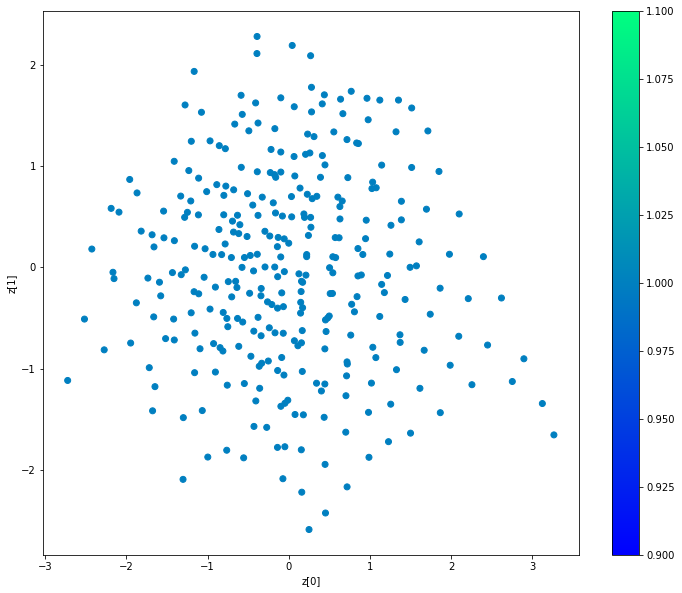

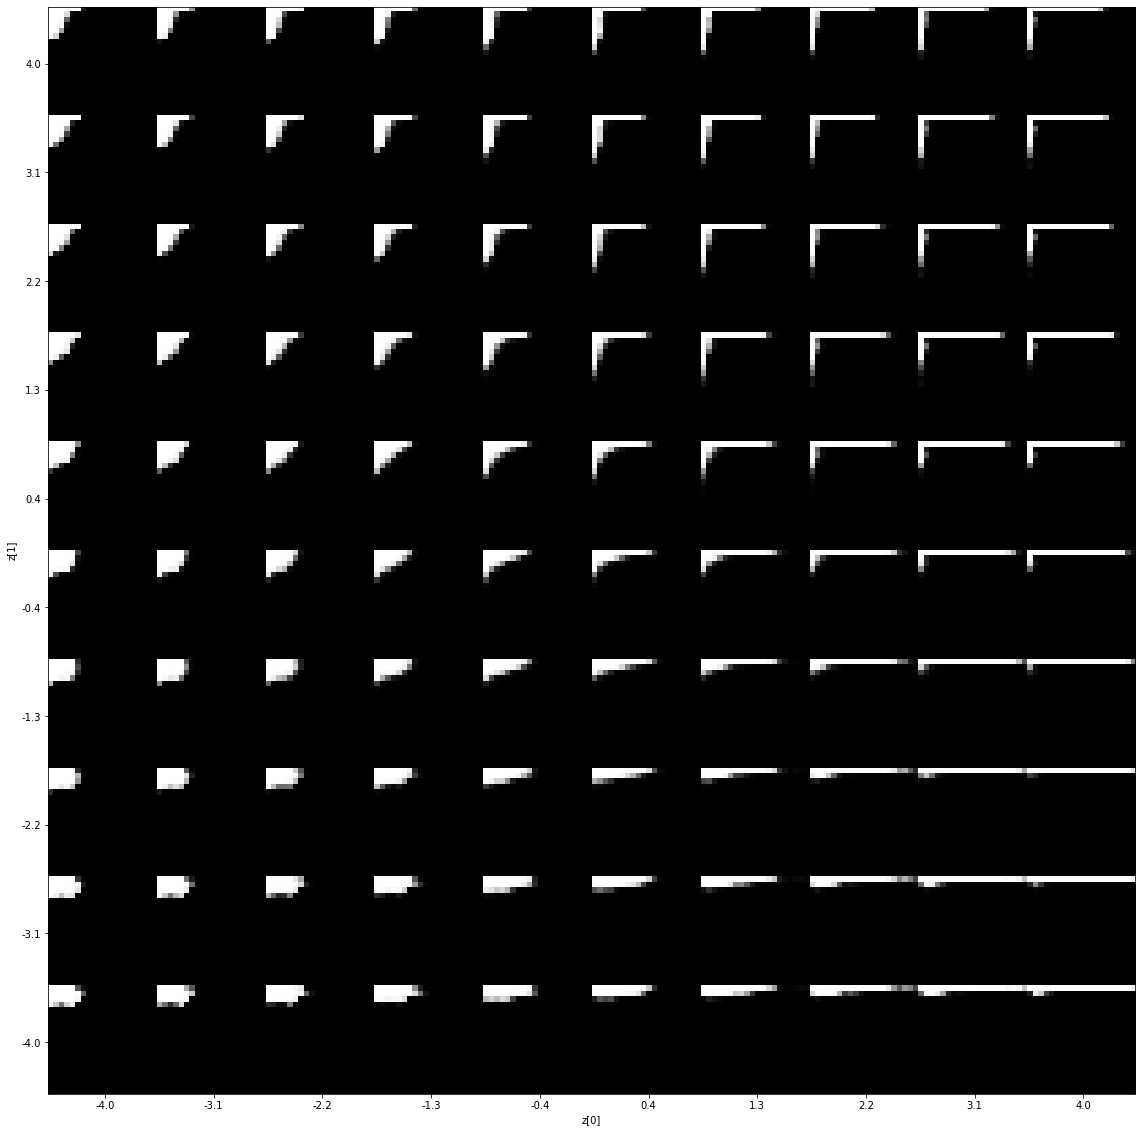

In [71]:
plot_results(models, (np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])),
             batch_size=batch_size, model_name="vae_mlp")

In [49]:
print(list(PartitionClass(23).partitions)[234])

▢▢▢▢▢▢▢
▢▢
▢▢
▢▢
▢▢
▢▢
▢
▢
▢
▢
▢
▢


In [53]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    X_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=colorings, cmap = 'winter')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename, transparent = True)
    plt.show()

    filename = os.path.join(model_name, "partitions_over_latent.png")
    # display a 30x30 2D manifold of digits
    grid = 10
    digit_size = n
    figure = np.zeros((digit_size * grid, digit_size * grid))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    
    if latent_dim == 2:
        grid_x = np.linspace(-4, 4, grid)
        grid_y = np.linspace(-4, 4, grid)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

    else:
        grid_x = np.linspace(-4, 4, grid)
        grid_y = np.linspace(-4, 4, grid)[::-1]
        grid_z = np.linspace(-4, 4, grid)[::-1]

        for i, zi in enumerate(grid_z):
            for i, yi in enumerate(grid_y):
                for j, xi in enumerate(grid_x):
                    z_sample = np.array([[xi, yi]])
                    x_decoded = decoder.predict(z_sample)
                    digit = x_decoded[0].reshape(digit_size, digit_size)
                    figure[i * digit_size: (i + 1) * digit_size,
                           j * digit_size: (j + 1) * digit_size] = digit
                
                
    scale = 2
    plt.figure(figsize=(grid * scale, grid * scale))
    start_range = digit_size // 2
    end_range = (grid - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename, transparent = True)
    plt.show()

In [171]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=[0, 1, 2],
    y=[0, 1, 2],
    z=[0, 1, 2],
    name="z",
))

fig.update_layout(
    scene=go.layout.Scene(
        aspectratio=dict(
            x=1,
            y=1,
            z=1
        ),
        camera=dict(
            center=dict(
                x=0,
                y=0,
                z=0
            ),
            eye=dict(
                x=1.96903462608,
                y=-1.09022831971,
                z=0.405345349304
            ),
            up=dict(
                x=0,
                y=0,
                z=1
            )
        ),
        dragmode="turntable",
    ),
    xaxis=dict(title_text="x"),
    yaxis=dict(title_text="y")
)






x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.8))


u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

x, y, z, u, v, w = list(map(lambda x: x.flatten(), [x, y, z, u, v, w]))

pl_deep = [[0.0, 'rgb(39, 26, 44)'],
           [0.1, 'rgb(53, 41, 74)'],
           [0.2, 'rgb(63, 57, 108)'],
           [0.3, 'rgb(64, 77, 139)'],
           [0.4, 'rgb(61, 99, 148)'],
           [0.5, 'rgb(65, 121, 153)'],
           [0.6, 'rgb(72, 142, 157)'],
           [0.7, 'rgb(80, 164, 162)'],
           [0.8, 'rgb(92, 185, 163)'],
           [0.9, 'rgb(121, 206, 162)'],
           [1.0, 'rgb(165, 222, 166)']]

fig.add_trace(go.Cone(
              x=[1 - .15],
              y=[1 - .15],
              z=[1 - .15],
              u=[5],
              v=[5],
              w=[5],
              sizemode='scaled',
              sizeref=0.025, #this is the default value,
              showscale=True,
              colorscale=pl_deep, 
              colorbar=dict(thickness=20, ticklen=4), 
              anchor='tail'
))


fig.show()

In [165]:
x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.8))


u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

x, y, z, u, v, w = list(map(lambda x: x.flatten(), [x, y, z, u, v, w]))

pl_deep = [[0.0, 'rgb(39, 26, 44)'],
           [0.1, 'rgb(53, 41, 74)'],
           [0.2, 'rgb(63, 57, 108)'],
           [0.3, 'rgb(64, 77, 139)'],
           [0.4, 'rgb(61, 99, 148)'],
           [0.5, 'rgb(65, 121, 153)'],
           [0.6, 'rgb(72, 142, 157)'],
           [0.7, 'rgb(80, 164, 162)'],
           [0.8, 'rgb(92, 185, 163)'],
           [0.9, 'rgb(121, 206, 162)'],
           [1.0, 'rgb(165, 222, 166)']]

fig = go.Figure()
fig.add_trace(go.Cone(
              x=[0],
              y=[0],
              z=[0],
              u=[100],
              v=[100],
              w=[100],
              sizemode='scaled',
              sizeref=0.025, #this is the default value,
              showscale=True,
              colorscale=pl_deep, 
              colorbar=dict(thickness=20, ticklen=4), 
              anchor='tail'
))
fig.show()

In [144]:
import plotly as py